In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "" #Path to kaggle API

In [2]:
!kaggle datasets download -d deadskull7/fer2013
!unzip \*.zip

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fer2013.zip
  inflating: fer2013.csv             


In [3]:
import numpy as np
import pandas as pd 
from PIL import Image
from tqdm import tqdm

import random

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
%matplotlib inline

In [4]:
data = pd.read_csv('fer2013.csv')
print (data.values.shape)
data.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
# convert string to integer
def atoi(s):
    n = 0
    for i in s:
        n = n*10 + ord(i) - ord("0")
    return n

# making folders
dir_names = ['test','train']
subdir_names = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
os.makedirs('data', exist_ok=True)
for outer_name in dir_names:
    os.makedirs(os.path.join('data',outer_name), exist_ok=True)
    for inner_name in subdir_names:
        os.makedirs(os.path.join('data',outer_name,inner_name), exist_ok=True)

# to keep count of each category
angry = 0
disgusted = 0
fearful = 0
happy = 0
sad = 0
surprised = 0
neutral = 0
angry_test = 0
disgusted_test = 0
fearful_test = 0
happy_test = 0
sad_test = 0
surprised_test = 0
neutral_test = 0

df = pd.read_csv('./fer2013.csv')
mat = np.zeros((48,48),dtype=np.uint8)
print("Saving images...")

# read the csv file line by line
for i in tqdm(range(len(df))):
    txt = df['pixels'][i]
    words = txt.split()
    
    # the image size is 48x48
    for j in range(2304):
        xind = j // 48
        yind = j % 48
        mat[xind][yind] = atoi(words[j])

    img = Image.fromarray(mat)

    # train
    if i < 28709:
        if df['emotion'][i] == 0:
            img.save('data/train/angry/im'+str(angry)+'.png')
            angry += 1
        elif df['emotion'][i] == 1:
            img.save('data/train/disgusted/im'+str(disgusted)+'.png')
            disgusted += 1
        elif df['emotion'][i] == 2:
            img.save('data/train/fearful/im'+str(fearful)+'.png')
            fearful += 1
        elif df['emotion'][i] == 3:
            img.save('data/train/happy/im'+str(happy)+'.png')
            happy += 1
        elif df['emotion'][i] == 4:
            img.save('data/train/sad/im'+str(sad)+'.png')
            sad += 1
        elif df['emotion'][i] == 5:
            img.save('data/train/surprised/im'+str(surprised)+'.png')
            surprised += 1
        elif df['emotion'][i] == 6:
            img.save('data/train/neutral/im'+str(neutral)+'.png')
            neutral += 1

    # test
    else:
        if df['emotion'][i] == 0:
            img.save('data/test/angry/im'+str(angry_test)+'.png')
            angry_test += 1
        elif df['emotion'][i] == 1:
            img.save('data/test/disgusted/im'+str(disgusted_test)+'.png')
            disgusted_test += 1
        elif df['emotion'][i] == 2:
            img.save('data/test/fearful/im'+str(fearful_test)+'.png')
            fearful_test += 1
        elif df['emotion'][i] == 3:
            img.save('data/test/happy/im'+str(happy_test)+'.png')
            happy_test += 1
        elif df['emotion'][i] == 4:
            img.save('data/test/sad/im'+str(sad_test)+'.png')
            sad_test += 1
        elif df['emotion'][i] == 5:
            img.save('data/test/surprised/im'+str(surprised_test)+'.png')
            surprised_test += 1
        elif df['emotion'][i] == 6:
            img.save('data/test/neutral/im'+str(neutral_test)+'.png')
            neutral_test += 1

print("Done!")

  0%|          | 32/35887 [00:00<01:53, 315.10it/s]

Saving images...


100%|██████████| 35887/35887 [01:33<00:00, 385.72it/s]

Done!


In [6]:
train_dir = 'data/train'
val_dir = 'data/test'

num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

In [7]:
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath = 'best_model.h5',save_best_only = True,verbose=1)

history = model.fit(
            train_generator,
            epochs=num_epoch,
            callbacks = [checkpoint],
            validation_data=validation_generator)

Epoch 1/50
448/449 [============================>.] - ETA: 0s - loss: 1.7968 - accuracy: 0.2643
Epoch 00001: val_loss improved from inf to 1.69679, saving model to best_model.h5
449/449 [==============================] - 10s 22ms/step - loss: 1.7966 - accuracy: 0.2643 - val_loss: 1.6968 - val_accuracy: 0.3385
Epoch 2/50
448/449 [============================>.] - ETA: 0s - loss: 1.6214 - accuracy: 0.3684
Epoch 00002: val_loss improved from 1.69679 to 1.53482, saving model to best_model.h5
449/449 [==============================] - 10s 22ms/step - loss: 1.6214 - accuracy: 0.3685 - val_loss: 1.5348 - val_accuracy: 0.4110
Epoch 3/50
447/449 [============================>.] - ETA: 0s - loss: 1.5188 - accuracy: 0.4168
Epoch 00003: val_loss improved from 1.53482 to 1.44740, saving model to best_model.h5
449/449 [==============================] - 10s 22ms/step - loss: 1.5189 - accuracy: 0.4168 - val_loss: 1.4474 - val_accuracy: 0.4496
Epoch 4/50
449/449 [==============================] - ETA: 

In [11]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5')

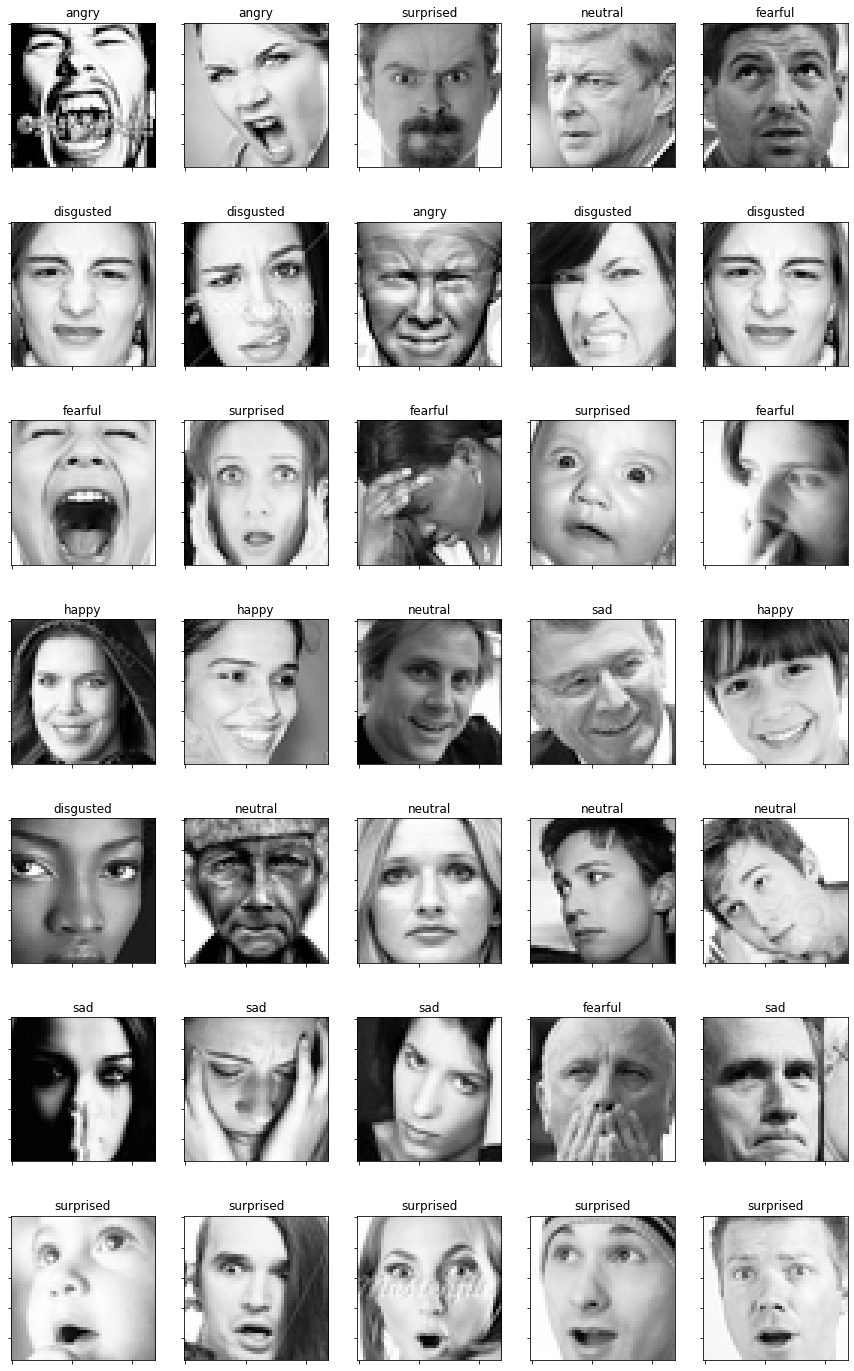

In [13]:
f, axarr = plt.subplots(7, 5,figsize=(15,25))

emotion = ['angry', 'disgusted', 'fearful', 'happy', 'neutral','sad', 'surprised']

for i in range(7):
    path = sorted(os.listdir("data/test"))[i]
    for j in range(5):
      img_path = "data/train/"+path+"/"+random.choice(os.listdir("data/test/"+path))
      image = cv2.imread(img_path)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      prediction = model.predict(gray.reshape(1, 48, 48, 1))[0]
      # 
      img = mpimg.imread(img_path)
      axarr[i,j].imshow(img, cmap = cm.Greys_r)
      # axarr[i,j].set_title(path)
      axarr[i,j].set_title(emotion[prediction.argmax()])
      # axarr[i,j].axis('off')
      # axarr[i,j].set_ylabel(emotion[prediction.argmax()])
      axarr[i,j].set_yticklabels([])
      axarr[i,j].set_xticklabels([])

f.savefig('test.png')

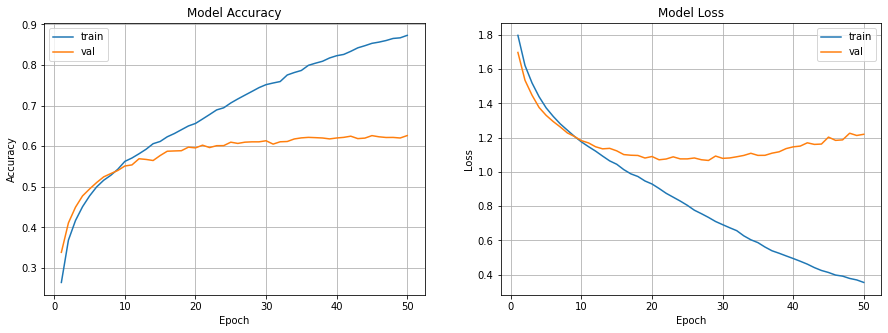

In [14]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
# summarize history for accuracy
axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].grid(True)
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='best')
# summarize history for loss
axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].grid(True)
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='best')
fig.savefig('graph.png')
plt.show()